In [3]:
import pandas as pd
import numpy as np
import itertools
import math
import os

from sklearn.model_selection import ShuffleSplit, StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt

try:
    import tensorflow as tf
    from tensorflow.keras.models import Sequential, Model
    from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D
    from tensorflow.keras.optimizers import SGD
except:
    os.system('python3 -m pip install tensorflow==2.7')
    import tensorflow as tf
    from tensorflow.keras.models import Sequential, Model
    from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D
    from tensorflow.keras.optimizers import SGD

# Artificial Neural Networks applied in Football Analytics I

During my project, I built different kinds of Artificial Neural Network (ANN) models in order to solve some problems and see new applications of data in sports analytics. To do so, I used TensorFlow, an open-source library for machine learning that is very optimised for this kind of models. I chose this library as it is one of the most popular ones.

As I started working with TensorFlow, I encountered a few backward-compatibility issues due to newer versions of the library not being able to run code written for older versions. Therefore, I made sure to use the same version of TensorFlow as the one used to prepare this project: 2.7 (latest stable version at the moment of writing this).

During the project, I built 3 different kinds of ANN, each to solve a different problem using a different dataset. I started by designing and training a Multilayer Perceptron (MLP) (or feedforward ANN) to compute a metric called Post-Shot Expected Goals (PSxG), which is the part discussed in this Notebook. Later on, I constructed a Convolutional Neural Network (CNN) to be used as an action selection model through spatial data. Finally, I designed an Autoencoder to reduce the dimensionality of a dataset consisting of aggregated player stats in order to apply clustering algorithms and find different groups of players.

It is worth noting that ANNs allow for lots of hyper-parameters to be tuned, as well as the many possible structures we can use. Finding the most appropriate design is sometimes regarded more as an art rather than a science, given that trying all possible combinations may be too power and time consuming. Due to the time limitation of my project, I only tried to find performance improvements by applying some tweaks on the model for the first exercise. For the rest, I focused on how can the different network structures be helpful given their nature. I didn't use methods such as cross-validation for model selection due to time limitations, but I am aware that these procedures should be used when dealing with real-world problems.

## 1. Multilayer Perceptron to create a PSxG model

As mentioned before, I started building a relatively simple neural network to model a metric called PSxG during my project. Similarly to xG, this one also predicts how likely a shot is to become a goal. However, it does so only for shots on target, and it takes into account post-shot information such as the location on the target where the ball is directed to or the speed of the shot. That is why this metric can be used to assess goalkeeping performance.

To train the model, I used a dataset that contained information on shots produced during different seasons. As a first step, I performed feature extraction to produce variables capable of expressing the information contained in the dataset in a way that is easier to understand for the model.

In [3]:
df_shots = pd.read_csv("data/df_shots.csv")
df_shots.head()

,origin_pos_x,origin_pos_y,destination_pos_x,destination_pos_y,destination_pos_z,gk_pos_x,gk_pos_y,duration,is_goal
0,0.890833,0.40125,1.0000,0.49875,0.45720,0.965000,0.47375,0.637257,1
1,0.815833,0.32375,0.9650,0.49250,0.54864,0.969167,0.47875,0.983675,0
2,0.673333,0.53500,0.9875,0.51250,1.18872,0.988333,0.49750,1.384115,0
3,0.913333,0.65500,1.0000,0.47625,0.36576,0.945000,0.60875,0.962551,1
4,0.916667,0.54000,1.0000,0.46000,0.18288,1.000000,0.51250,0.904610,1


I started by transforming the y-coordinate positions into mirrored coordinates. This transformation consists of converting the y-coordinate values so that they disregard which half of the pitch they are in, which will be helpful in simplifying the model. This assumption is based on the idea that the model will produce symmetric results regarding the center of the field. After transformation, the new variables' value ranges between 0 and 0.5. For example, this transformation should convert two different y-coordinate values such as 0.4 and 0.6 into the same transformed value since they are both at the same distance from the center of the field, the 0.5 position.

I applied this transformation to the following variables: origin_pos_y, destination_pos_y, and gk_pos_y.

In [4]:
pitch_dim = [105,68]

def distance_between_two_points(p1, p2):
    return np.linalg.norm(p2 - p1)

In [5]:
df_shots['origin_y_dist_center'] = df_shots.apply(lambda row: distance_between_two_points(
                                        np.array([row.origin_pos_x,row.origin_pos_y])*pitch_dim,
                                        np.array([row.origin_pos_x,0.5])*pitch_dim),axis=1)

df_shots['destination_y_dist_center'] = df_shots.apply(lambda row: distance_between_two_points(
                                        np.array([row.destination_pos_x,row.destination_pos_y])*pitch_dim,
                                        np.array([row.destination_pos_x,0.5])*pitch_dim),axis=1)

df_shots['gk_y_dist_center'] = df_shots.apply(lambda row: distance_between_two_points(
                                        np.array([row.gk_pos_x,row.gk_pos_y])*pitch_dim,
                                        np.array([row.gk_pos_x,0.5])*pitch_dim),axis=1)

I converted the x-y-coordinates into distances. Before doing so, I first transformed the positions into meters, since the field is 105m long and 68m wide, but both original coordinates were normalized using a range between 0 and 1. The distances that I calculated were the shot distance (origin-destination), the distance between the keeper and the destination (gk-destination), and the distance between the keeper and the shooter (origin-gk).

In [6]:
df_shots['shot_distance'] = df_shots.apply(lambda row: distance_between_two_points(
                                        np.array([row.origin_pos_x,row.origin_pos_y])*pitch_dim,
                                        np.array([row.destination_pos_x,row.destination_pos_y])*pitch_dim),axis=1)

df_shots['gk_distance_destination'] = df_shots.apply(lambda row: distance_between_two_points(
                                        np.array([row.gk_pos_x,row.gk_pos_y])*pitch_dim,
                                        np.array([row.destination_pos_x,row.destination_pos_y])*pitch_dim),axis=1)

df_shots['gk_distance_shooter'] = df_shots.apply(lambda row: distance_between_two_points(
                                        np.array([row.origin_pos_x,row.origin_pos_y])*pitch_dim,
                                        np.array([row.gk_pos_x,row.gk_pos_y])*pitch_dim),axis=1)

I computed 2 different angle variables. Firstly, I calculated the angle between the shot position and the destination of the shot. Secondly, I calculated the angle between the shot position and the goalkeeper. Note that the angle between 2 points can be computed as follows:
```python
abs(np.arctan2(distance_in_y, distance_in_x))
```
In this formula, the distances refer to the distance between the 1st and 2nd point for each dimension. To compute an accurate angle, both distances should be expressed in meters.

In [7]:
def angle_two_points(origin, destination):

    distance_in_y = destination[1]-origin[1]
    distance_in_x = destination[0]-origin[0]
    
    return abs(np.arctan2(distance_in_y, distance_in_x))

df_shots['angle_origin_destination'] = df_shots.apply(lambda row: angle_two_points(
                                            np.array([row.origin_pos_x,row.origin_pos_y])*pitch_dim,
                                            np.array([row.destination_pos_x,row.destination_pos_y])*pitch_dim),axis=1)
df_shots['angle_origin_gk'] = df_shots.apply(lambda row: angle_two_points(
                                            np.array([row.origin_pos_x,row.origin_pos_y])*pitch_dim,
                                            np.array([row.gk_pos_x,row.gk_pos_y])*pitch_dim),axis=1)

As we will see later on, I needed a second response variable since I was trying to solve a classification problem (goal or not goal). To do this, I used one-hot encoding to convert the is_goal variable. Therefore, I ended up having 2 different variables: is_goal and is_not_goal. For goals, is_goal was set to 1 and is_not_goal to 0, and vice versa for not goals. To create the is_not_goal variable, I simply subtracted the is_goal variable from 1.

In [9]:
df_shots['is_not_goal'] = abs(df_shots['is_goal']-1)

I split the dataframe columns into two new dataframes: X and y. X includes the newly created variables (except for is_not_goal), as well as destination_pos_z and duration. On the other hand, y includes the response variables is_goal and is_not_goal. This split allows for easier handling and manipulation of the data during the modelling stage.

In [10]:
explanatory_vars = ['gk_y_dist_center','origin_y_dist_center','destination_y_dist_center',
                    'destination_pos_z','duration','shot_distance','gk_distance_destination','gk_distance_shooter',
                    'angle_origin_destination','angle_origin_gk']
response_vars = ['is_goal','is_not_goal']

X = df_shots[explanatory_vars]
y = df_shots[response_vars]

I will now split the dataset into train and test, in order to have a set of data different from the one we used to fit the model to obtain performance results on unseen data. Note that, once again, the response variables are unbalanced. Therefore, I will need to use a stratified split.

In [11]:
indexes = list(StratifiedShuffleSplit(n_splits=1, test_size=0.33, random_state=1234).split(X, y))[0]
train_index, test_index = indexes
X_train, X_test, y_train, y_test = X.loc[train_index], X.loc[test_index], y.loc[train_index], y.loc[test_index]

In [12]:
y_train.mean(), y_test.mean()

(is_goal        0.322249
 is_not_goal    0.677751
 dtype: float64,
 is_goal        0.322272
 is_not_goal    0.677728
 dtype: float64)

The next cell presents a group of methods that I will use to train and evaluate the NN models I create. This will be helpful to allow changing model parameters and configurations in a simplified manner. The methods are pretty straight-forward.

In [5]:
def train_and_evaluate_model(m, _data, loss="mean_squared_error", metrics=["accuracy", "mean_squared_error"], learning_rate=0.1, momentum=0.0, epochs=50, batch_size=64, verbose=1):
    evaluate_model(train_model(m, _data, loss, metrics, learning_rate, momentum, epochs, batch_size, verbose), _data, metrics)

def train_model(m, _data, loss="mean_squared_error", metrics=["accuracy", "mean_squared_error"], learning_rate=0.1, momentum=0.0, epochs=50, batch_size=64, verbose=1):
    tf.random.set_seed(1234)
    m.compile(optimizer=SGD(learning_rate=learning_rate, momentum=momentum), loss=loss, metrics=metrics)
    m.fit(_data["X_train"], _data["y_train"], epochs=epochs , batch_size=batch_size, validation_split=0.2, verbose=verbose)
    return m

def evaluate_model(m, _data, metrics):
    r = m.evaluate(_data["X_test"], _data["y_test"], verbose=0)
    print("\n" + " | ".join("{0}: {1}".format(metric, value) for metric, value in zip(metrics, r[1:])))

You will have noticed that apart from the model m, the methods require a dictionary containing the different partitions. Therefore, I will generate this dictionary containing the partitions I have previously generated. I it important to scale the X_* partitions.

In [14]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(np.array(X_train))
X_test_scaled = scaler.fit_transform(np.array(X_test))

data = {}
data['X_train'] = X_train_scaled
data['X_test'] = X_test_scaled
data['y_train'] = y_train
data['y_test'] = y_test

It is now time to start producing models. And I will begin with the simplest one possible. I will use the default parameters and will construct a neural network without hidden layers. So the only layers contained will be the input layer (with the same dimensions as the input -> 10) and the output layer (with the same dimensions as the output -> 2). The following diagram illustrates the structure mentioned.

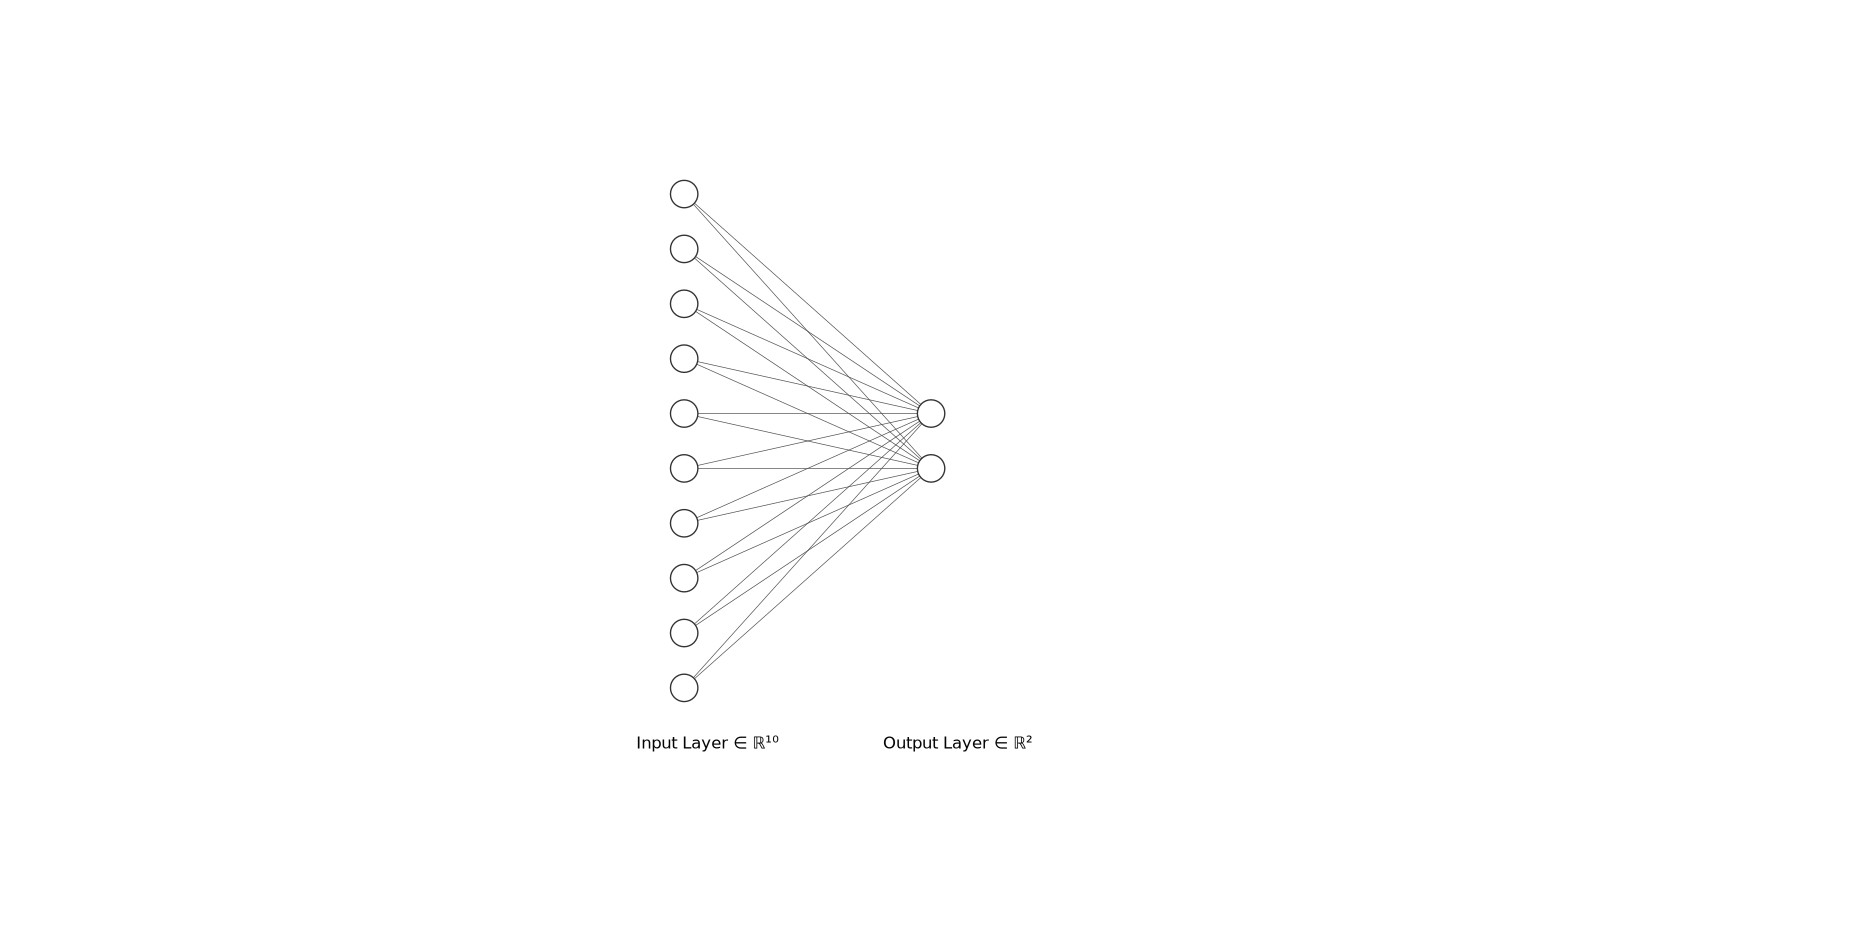

In [15]:
from IPython.core.display import SVG
SVG(filename='assets/nn-0-hidden.svg')

The previous structure was modeled using TensorFlow with the code of the following cell. I simply listed the layers in an ordered manner, and for each I specified the shape of its output as well as their activation function. For the MLPs I only used Dense layers, but you will see later on that other types of NNs use other layers. Note that the input layer does not need to be declared, given that its shape is inferred from the input data. The output shape of the output layer must match the number of response variables we are trying to predict. Finally, I used the sigmoid activation function for the output layer since the expected outputs should be in the range between 0 and 1.

In [16]:
model = Sequential([
    # output layer
    Dense(2, activation='sigmoid'),
])
train_and_evaluate_model(model, data)

Epoch 1/50
469/469 [==============================] - 2s 3ms/step - loss: 0.1314 - accuracy: 0.8434 - mean_squared_error: 0.1314 - val_loss: 0.0945 - val_accuracy: 0.8912 - val_mean_squared_error: 0.0945
Epoch 2/50
469/469 [==============================] - 1s 2ms/step - loss: 0.0904 - accuracy: 0.8930 - mean_squared_error: 0.0904 - val_loss: 0.0838 - val_accuracy: 0.8959 - val_mean_squared_error: 0.0838
Epoch 3/50
469/469 [==============================] - 1s 2ms/step - loss: 0.0834 - accuracy: 0.8968 - mean_squared_error: 0.0834 - val_loss: 0.0794 - val_accuracy: 0.8975 - val_mean_squared_error: 0.0794
Epoch 4/50
469/469 [==============================] - 2s 4ms/step - loss: 0.0799 - accuracy: 0.8991 - mean_squared_error: 0.0799 - val_loss: 0.0769 - val_accuracy: 0.9005 - val_mean_squared_error: 0.0769
Epoch 5/50
469/469 [==============================] - 2s 4ms/step - loss: 0.0778 - accuracy: 0.9006 - mean_squared_error: 0.0778 - val_loss: 0.0752 - val_accuracy: 0.9025 - val_mean_sq

469/469 [==============================] - 1s 2ms/step - loss: 0.0670 - accuracy: 0.9117 - mean_squared_error: 0.0670 - val_loss: 0.0655 - val_accuracy: 0.9128 - val_mean_squared_error: 0.0655
Epoch 42/50
469/469 [==============================] - 1s 3ms/step - loss: 0.0669 - accuracy: 0.9121 - mean_squared_error: 0.0669 - val_loss: 0.0654 - val_accuracy: 0.9129 - val_mean_squared_error: 0.0654
Epoch 43/50
469/469 [==============================] - 1s 2ms/step - loss: 0.0668 - accuracy: 0.9122 - mean_squared_error: 0.0668 - val_loss: 0.0653 - val_accuracy: 0.9135 - val_mean_squared_error: 0.0653
Epoch 44/50
469/469 [==============================] - 1s 2ms/step - loss: 0.0667 - accuracy: 0.9120 - mean_squared_error: 0.0667 - val_loss: 0.0652 - val_accuracy: 0.9139 - val_mean_squared_error: 0.0652
Epoch 45/50
469/469 [==============================] - 1s 2ms/step - loss: 0.0666 - accuracy: 0.9122 - mean_squared_error: 0.0666 - val_loss: 0.0651 - val_accuracy: 0.9139 - val_mean_squared_e

The training method prints the performance of the model after each epoch, as well as the final performance metrics obtained using the test set. For this exercise, I looked at the accuracy of the model (the higher the better) and its mean squared error (the lower the better) to assess its performance. At this point, it was hard to say whether the model was doing well or not because I had nothing to compare it to, but +90% of accuracy didn't look bad. However, I knew that there was a big margin of improvement.

I then added the first hidden layer to the model. The previous model worked similarly to a logistic regression, since the structure didn't allow the model to learn non-linear relations between the predictor variables and the response variables. Adding a hidden layer fixed that. The new structure looked like the following diagram.

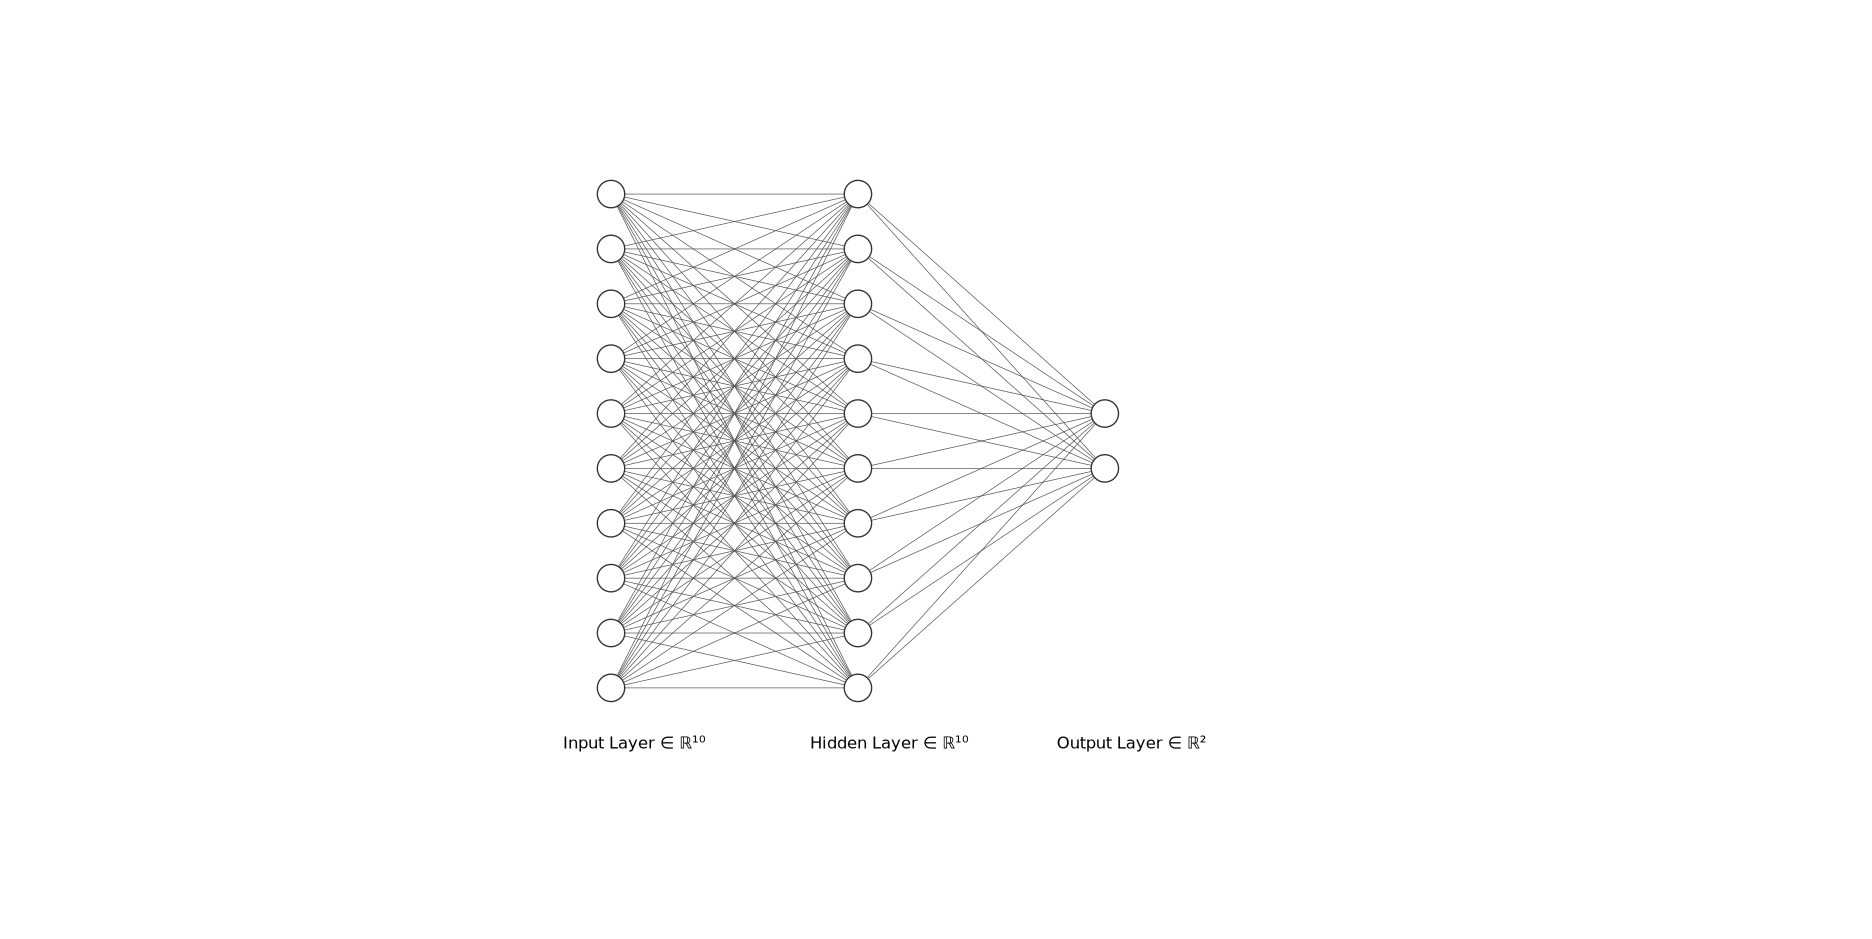

In [17]:
from IPython.core.display import SVG
SVG(filename='assets/nn-1-hidden.svg')

The number of neurons of the hidden layer was set to 10 (the same as the input layer). As mentioned in the introduction, I did not try many possible combinations of structures as it would have taken too much time. Keeping the number of neurons the same as the previous layer tends to yield good results. For now, I also used the sigmoid as the activation function of the hidden layer. I created the new model using the previous one as an example, and trained and evaluated it as before. It is important to note that the hidden layer was added before the output, and not after.

In [18]:
model = Sequential([
    Dense(10, activation='sigmoid'),
    # output layer
    Dense(2, activation='sigmoid'),
])
train_and_evaluate_model(model, data)

Epoch 1/50
469/469 [==============================] - 1s 2ms/step - loss: 0.2069 - accuracy: 0.6780 - mean_squared_error: 0.2069 - val_loss: 0.1781 - val_accuracy: 0.7038 - val_mean_squared_error: 0.1781
Epoch 2/50
469/469 [==============================] - 1s 2ms/step - loss: 0.1505 - accuracy: 0.7918 - mean_squared_error: 0.1505 - val_loss: 0.1217 - val_accuracy: 0.8652 - val_mean_squared_error: 0.1217
Epoch 3/50
469/469 [==============================] - 1s 2ms/step - loss: 0.1082 - accuracy: 0.8759 - mean_squared_error: 0.1082 - val_loss: 0.0945 - val_accuracy: 0.8888 - val_mean_squared_error: 0.0945
Epoch 4/50
469/469 [==============================] - 1s 2ms/step - loss: 0.0905 - accuracy: 0.8922 - mean_squared_error: 0.0905 - val_loss: 0.0839 - val_accuracy: 0.8969 - val_mean_squared_error: 0.0839
Epoch 5/50
469/469 [==============================] - 1s 2ms/step - loss: 0.0830 - accuracy: 0.8974 - mean_squared_error: 0.0830 - val_loss: 0.0787 - val_accuracy: 0.8993 - val_mean_sq

469/469 [==============================] - 1s 2ms/step - loss: 0.0639 - accuracy: 0.9148 - mean_squared_error: 0.0639 - val_loss: 0.0624 - val_accuracy: 0.9167 - val_mean_squared_error: 0.0624
Epoch 42/50
469/469 [==============================] - 2s 3ms/step - loss: 0.0636 - accuracy: 0.9154 - mean_squared_error: 0.0636 - val_loss: 0.0622 - val_accuracy: 0.9168 - val_mean_squared_error: 0.0622
Epoch 43/50
469/469 [==============================] - 2s 5ms/step - loss: 0.0634 - accuracy: 0.9156 - mean_squared_error: 0.0634 - val_loss: 0.0619 - val_accuracy: 0.9177 - val_mean_squared_error: 0.0619
Epoch 44/50
469/469 [==============================] - 2s 5ms/step - loss: 0.0632 - accuracy: 0.9156 - mean_squared_error: 0.0632 - val_loss: 0.0617 - val_accuracy: 0.9181 - val_mean_squared_error: 0.0617
Epoch 45/50
469/469 [==============================] - 2s 5ms/step - loss: 0.0629 - accuracy: 0.9163 - mean_squared_error: 0.0629 - val_loss: 0.0615 - val_accuracy: 0.9183 - val_mean_squared_e

Notice the improvement I achieved compared to the previous and simpler model. But I didn't stop there. I then focused on the activation functions. Each function used has different properties, and apart from adding non-linearity to the model predictions, they regulate the range of the output produced by the layer. But on the back-propagation stage they also affect the size of the correction applied to the weights in order to learn from the new data. This correction is known as the gradient, which corresponds to the derivative of the function with respect to the weights. Which means that the steeper the function (the higher the slope) the higher will be their gradients. With larger gradients, I would need fewer steps to reach the optimal solution, which would reduce the needed time to reach loss convergence. The disadvantage of taking big steps might be that I skip the best solution, but there are other parameters such as the learning rate that help to minimize this problem. The following plot compares the sigmoid and relu activation functions.

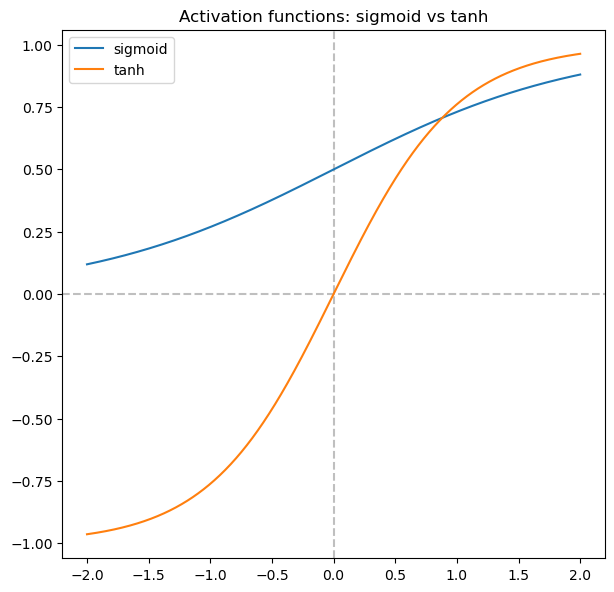

In [19]:
sigmoid = lambda x: [1 / (1 + math.exp(-item)) for item in x]
tanh = lambda x: np.tanh(x)

x_values = np.linspace(-2, 2, 1000)

fig, ax = plt.subplots(figsize=(7, 7), dpi=100)
ax.axhline(0, ls='--', c="gray", alpha=0.5)
ax.axvline(0, ls='--', c="gray", alpha=0.5)
ax.plot(x_values, sigmoid(x_values), label="sigmoid")
ax.plot(x_values, tanh(x_values), label="tanh")
ax.set_title("Activation functions: sigmoid vs tanh")
ax.legend()

It is clear to see that the tanh is much steeper than the sigmoid. So I decided to try using this function as the activation function of the hidden layer instead of the sigmoid. However, I didn't use it on the output layer as it would reduce the performance of the model. The reason is that the predictions produced by the tanh function will be in the range [-1, 1], which is different than the range we expect [0, 1].

In [20]:
model = Sequential([
    Dense(10, activation='tanh'),
    # output layer
    Dense(2, activation='sigmoid'),
])
train_and_evaluate_model(model, data)

Epoch 1/50
469/469 [==============================] - 2s 3ms/step - loss: 0.1337 - accuracy: 0.8311 - mean_squared_error: 0.1337 - val_loss: 0.0815 - val_accuracy: 0.9000 - val_mean_squared_error: 0.0815
Epoch 2/50
469/469 [==============================] - 1s 2ms/step - loss: 0.0777 - accuracy: 0.9005 - mean_squared_error: 0.0777 - val_loss: 0.0723 - val_accuracy: 0.9064 - val_mean_squared_error: 0.0723
Epoch 3/50
469/469 [==============================] - 1s 2ms/step - loss: 0.0728 - accuracy: 0.9044 - mean_squared_error: 0.0728 - val_loss: 0.0697 - val_accuracy: 0.9069 - val_mean_squared_error: 0.0697
Epoch 4/50
469/469 [==============================] - 1s 2ms/step - loss: 0.0708 - accuracy: 0.9059 - mean_squared_error: 0.0708 - val_loss: 0.0683 - val_accuracy: 0.9107 - val_mean_squared_error: 0.0683
Epoch 5/50
469/469 [==============================] - 1s 2ms/step - loss: 0.0695 - accuracy: 0.9069 - mean_squared_error: 0.0695 - val_loss: 0.0671 - val_accuracy: 0.9105 - val_mean_sq

469/469 [==============================] - 1s 3ms/step - loss: 0.0490 - accuracy: 0.9366 - mean_squared_error: 0.0490 - val_loss: 0.0494 - val_accuracy: 0.9361 - val_mean_squared_error: 0.0494
Epoch 42/50
469/469 [==============================] - 2s 4ms/step - loss: 0.0488 - accuracy: 0.9367 - mean_squared_error: 0.0488 - val_loss: 0.0494 - val_accuracy: 0.9372 - val_mean_squared_error: 0.0494
Epoch 43/50
469/469 [==============================] - 1s 3ms/step - loss: 0.0487 - accuracy: 0.9366 - mean_squared_error: 0.0487 - val_loss: 0.0493 - val_accuracy: 0.9365 - val_mean_squared_error: 0.0493
Epoch 44/50
469/469 [==============================] - 1s 3ms/step - loss: 0.0486 - accuracy: 0.9367 - mean_squared_error: 0.0486 - val_loss: 0.0489 - val_accuracy: 0.9375 - val_mean_squared_error: 0.0489
Epoch 45/50
469/469 [==============================] - 2s 3ms/step - loss: 0.0483 - accuracy: 0.9366 - mean_squared_error: 0.0483 - val_loss: 0.0488 - val_accuracy: 0.9383 - val_mean_squared_e

Note the large improvement obtained. The next configuration to modify will be the loss function. The default we are using right now is the mean squared error, which is not the best when we know that the output corresponds to probabilities. On the other hand, the Cross Entropy Loss works very well for this problem, given that the loss values produced for predictions close the incorrect value increase exponentially towards infinity. The mean squared error's maximum loss is 1 for probabilities. Larger loss values will also produce larger gradients. Try adding as the last parameter passed to the train_and_evaluate_model method the following: loss="binary_crossentropy".

I want to point out the large improvement obtained. The next configuration I will modify is the loss function. The default being used right now is the mean squared error, which is not the best when we know that the output corresponds to probabilities. On the other hand, the Cross Entropy Loss works very well for this problem, given that the loss values produced for predictions close the incorrect value increase exponentially towards infinity. The mean squared error's maximum loss is 1 for probabilities. Larger loss values will also produce larger gradients. I added as the last parameter passed to the train_and_evaluate_model method the following: loss="binary_crossentropy".

In [21]:
model = Sequential([
    Dense(10, activation='tanh'),
    # output layer
    Dense(2, activation='sigmoid'),
])
train_and_evaluate_model(model, data, loss="binary_crossentropy")

Epoch 1/50
469/469 [==============================] - 2s 3ms/step - loss: 0.3301 - accuracy: 0.8667 - mean_squared_error: 0.1007 - val_loss: 0.2414 - val_accuracy: 0.9051 - val_mean_squared_error: 0.0703
Epoch 2/50
469/469 [==============================] - 1s 2ms/step - loss: 0.2392 - accuracy: 0.9050 - mean_squared_error: 0.0704 - val_loss: 0.2300 - val_accuracy: 0.9121 - val_mean_squared_error: 0.0667
Epoch 3/50
469/469 [==============================] - 1s 2ms/step - loss: 0.2286 - accuracy: 0.9099 - mean_squared_error: 0.0673 - val_loss: 0.2219 - val_accuracy: 0.9139 - val_mean_squared_error: 0.0642
Epoch 4/50
469/469 [==============================] - 1s 2ms/step - loss: 0.2190 - accuracy: 0.9133 - mean_squared_error: 0.0643 - val_loss: 0.2137 - val_accuracy: 0.9167 - val_mean_squared_error: 0.0618
Epoch 5/50
469/469 [==============================] - 1s 2ms/step - loss: 0.2105 - accuracy: 0.9165 - mean_squared_error: 0.0617 - val_loss: 0.2053 - val_accuracy: 0.9203 - val_mean_sq

469/469 [==============================] - 2s 5ms/step - loss: 0.1485 - accuracy: 0.9433 - mean_squared_error: 0.0427 - val_loss: 0.1548 - val_accuracy: 0.9432 - val_mean_squared_error: 0.0434
Epoch 42/50
469/469 [==============================] - 2s 5ms/step - loss: 0.1481 - accuracy: 0.9442 - mean_squared_error: 0.0425 - val_loss: 0.1542 - val_accuracy: 0.9429 - val_mean_squared_error: 0.0433
Epoch 43/50
469/469 [==============================] - 2s 4ms/step - loss: 0.1473 - accuracy: 0.9440 - mean_squared_error: 0.0422 - val_loss: 0.1569 - val_accuracy: 0.9431 - val_mean_squared_error: 0.0441
Epoch 44/50
469/469 [==============================] - 1s 3ms/step - loss: 0.1474 - accuracy: 0.9440 - mean_squared_error: 0.0423 - val_loss: 0.1538 - val_accuracy: 0.9443 - val_mean_squared_error: 0.0431
Epoch 45/50
469/469 [==============================] - 2s 4ms/step - loss: 0.1467 - accuracy: 0.9447 - mean_squared_error: 0.0420 - val_loss: 0.1533 - val_accuracy: 0.9453 - val_mean_squared_e

Again, we observe an increase in the performance of the model. The next parameter to modify will be the momentum. The momentum can be interpreted as the inertia kept by the weight updates. So when it's time to update a weight using the obtained gradient, it will also consider the previous gradients obtained for that weight. Each of the previous gradients will be weighted in an exponential decay determined by the value of the momentum parameter. This will help for example to avoid getting stuck in local minima. For this, I tried adding momentum=0.9 as a new parameter.

In [22]:
model = Sequential([
    Dense(10, activation='tanh'),
    # output layer
    Dense(2, activation='sigmoid'),
])
train_and_evaluate_model(model, data, loss="binary_crossentropy", momentum=0.9)

Epoch 1/50
469/469 [==============================] - 2s 2ms/step - loss: 0.2394 - accuracy: 0.9017 - mean_squared_error: 0.0718 - val_loss: 0.1945 - val_accuracy: 0.9208 - val_mean_squared_error: 0.0567
Epoch 2/50
469/469 [==============================] - 1s 2ms/step - loss: 0.1836 - accuracy: 0.9277 - mean_squared_error: 0.0537 - val_loss: 0.1812 - val_accuracy: 0.9315 - val_mean_squared_error: 0.0514
Epoch 3/50
469/469 [==============================] - 2s 5ms/step - loss: 0.1687 - accuracy: 0.9350 - mean_squared_error: 0.0491 - val_loss: 0.1641 - val_accuracy: 0.9388 - val_mean_squared_error: 0.0465
Epoch 4/50
469/469 [==============================] - 2s 5ms/step - loss: 0.1634 - accuracy: 0.9372 - mean_squared_error: 0.0474 - val_loss: 0.1603 - val_accuracy: 0.9412 - val_mean_squared_error: 0.0450
Epoch 5/50
469/469 [==============================] - 3s 5ms/step - loss: 0.1588 - accuracy: 0.9382 - mean_squared_error: 0.0461 - val_loss: 0.1618 - val_accuracy: 0.9381 - val_mean_sq

469/469 [==============================] - 2s 4ms/step - loss: 0.1340 - accuracy: 0.9490 - mean_squared_error: 0.0385 - val_loss: 0.1379 - val_accuracy: 0.9504 - val_mean_squared_error: 0.0379
Epoch 42/50
469/469 [==============================] - 2s 4ms/step - loss: 0.1334 - accuracy: 0.9491 - mean_squared_error: 0.0384 - val_loss: 0.1386 - val_accuracy: 0.9489 - val_mean_squared_error: 0.0387
Epoch 43/50
469/469 [==============================] - 2s 4ms/step - loss: 0.1326 - accuracy: 0.9497 - mean_squared_error: 0.0381 - val_loss: 0.1446 - val_accuracy: 0.9481 - val_mean_squared_error: 0.0403
Epoch 44/50
469/469 [==============================] - 2s 4ms/step - loss: 0.1334 - accuracy: 0.9489 - mean_squared_error: 0.0382 - val_loss: 0.1385 - val_accuracy: 0.9492 - val_mean_squared_error: 0.0385
Epoch 45/50
469/469 [==============================] - 2s 4ms/step - loss: 0.1323 - accuracy: 0.9498 - mean_squared_error: 0.0379 - val_loss: 0.1373 - val_accuracy: 0.9521 - val_mean_squared_e

We see that the metrics improve again. I will try now to add a second hidden layer with tanh as the activation function. Note that adding more hidden layers increases the complexity of the model, which can sometimes lead to poorer performances. The new network should look as the following diagram.

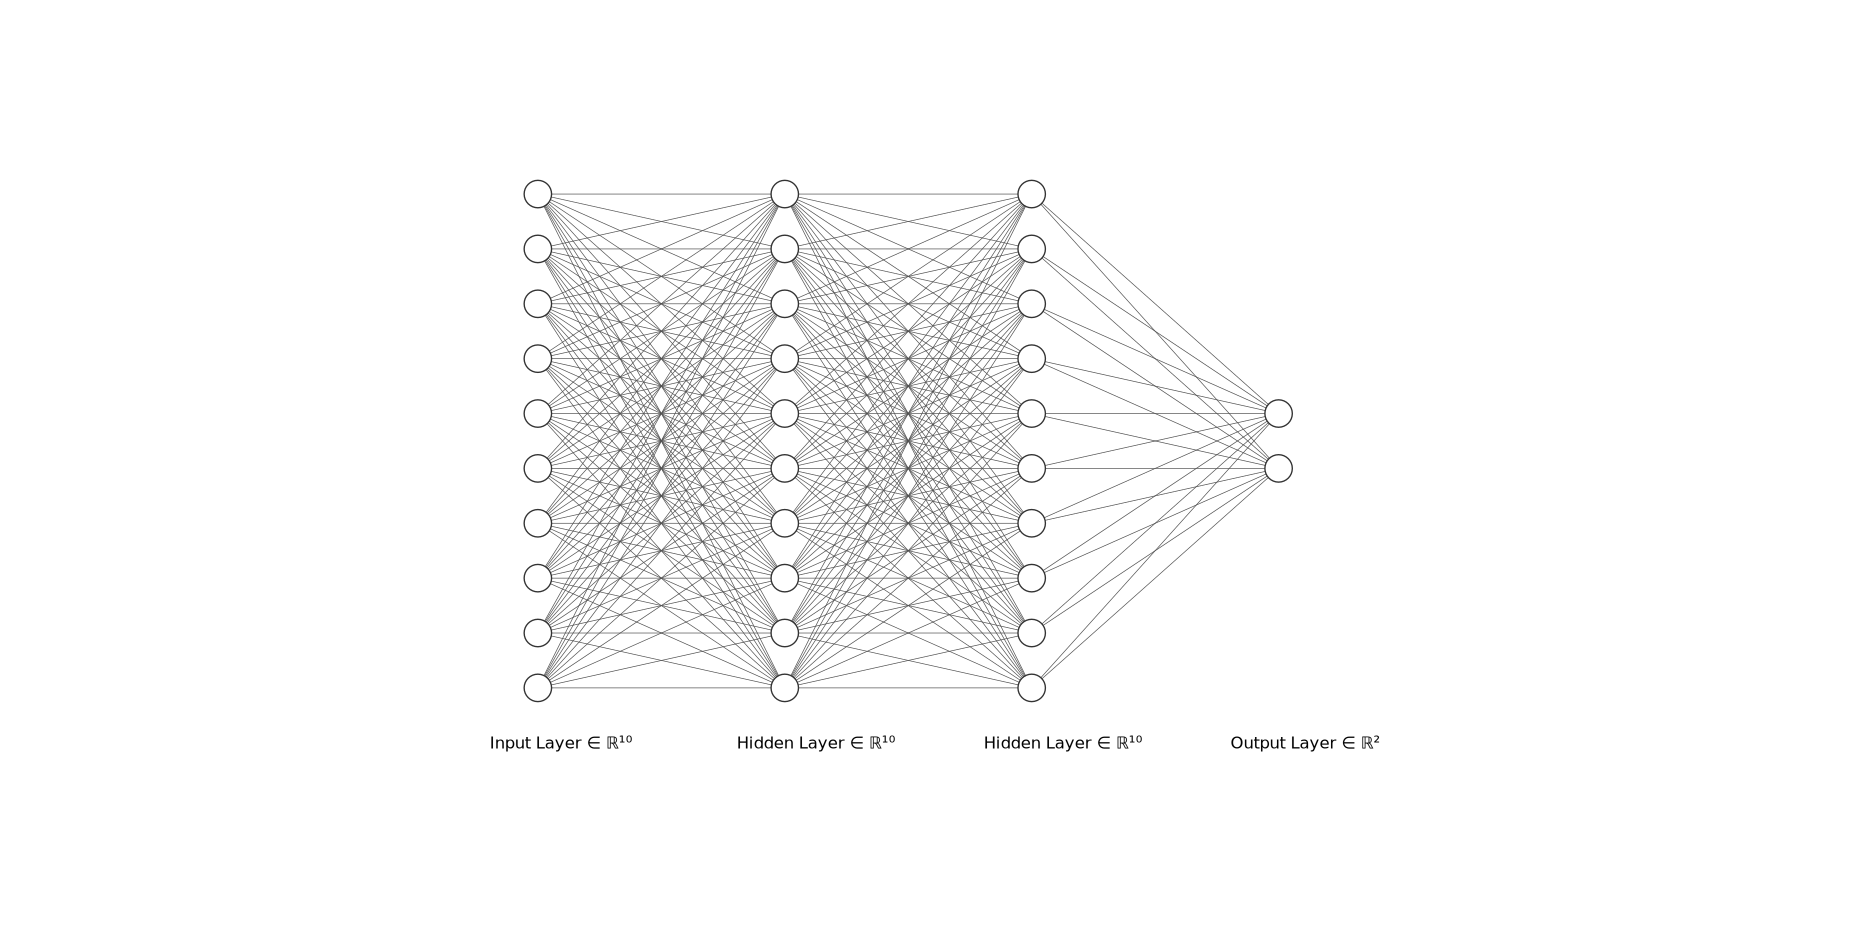

In [23]:
from IPython.core.display import SVG
SVG(filename='assets/nn-2-hidden.svg')

In [24]:
model = Sequential([
    Dense(10, activation='tanh'),
    Dense(10, activation='tanh'),
    # output layer
    Dense(2, activation='sigmoid'),
])
train_and_evaluate_model(model, data, loss="binary_crossentropy", momentum=0.9)

Epoch 1/50
469/469 [==============================] - 2s 3ms/step - loss: 0.2263 - accuracy: 0.9075 - mean_squared_error: 0.0675 - val_loss: 0.1913 - val_accuracy: 0.9243 - val_mean_squared_error: 0.0557
Epoch 2/50
469/469 [==============================] - 1s 2ms/step - loss: 0.1777 - accuracy: 0.9303 - mean_squared_error: 0.0519 - val_loss: 0.1795 - val_accuracy: 0.9312 - val_mean_squared_error: 0.0516
Epoch 3/50
469/469 [==============================] - 1s 3ms/step - loss: 0.1675 - accuracy: 0.9352 - mean_squared_error: 0.0488 - val_loss: 0.1579 - val_accuracy: 0.9411 - val_mean_squared_error: 0.0449
Epoch 4/50
469/469 [==============================] - 1s 3ms/step - loss: 0.1596 - accuracy: 0.9393 - mean_squared_error: 0.0461 - val_loss: 0.1527 - val_accuracy: 0.9393 - val_mean_squared_error: 0.0440
Epoch 5/50
469/469 [==============================] - 1s 3ms/step - loss: 0.1567 - accuracy: 0.9396 - mean_squared_error: 0.0454 - val_loss: 0.1534 - val_accuracy: 0.9413 - val_mean_sq

469/469 [==============================] - 3s 5ms/step - loss: 0.1274 - accuracy: 0.9512 - mean_squared_error: 0.0366 - val_loss: 0.1397 - val_accuracy: 0.9480 - val_mean_squared_error: 0.0388
Epoch 42/50
469/469 [==============================] - 3s 5ms/step - loss: 0.1264 - accuracy: 0.9510 - mean_squared_error: 0.0365 - val_loss: 0.1330 - val_accuracy: 0.9496 - val_mean_squared_error: 0.0379
Epoch 43/50
469/469 [==============================] - 3s 5ms/step - loss: 0.1268 - accuracy: 0.9517 - mean_squared_error: 0.0364 - val_loss: 0.1426 - val_accuracy: 0.9447 - val_mean_squared_error: 0.0409
Epoch 44/50
469/469 [==============================] - 3s 5ms/step - loss: 0.1271 - accuracy: 0.9514 - mean_squared_error: 0.0365 - val_loss: 0.1411 - val_accuracy: 0.9485 - val_mean_squared_error: 0.0400
Epoch 45/50
469/469 [==============================] - 3s 5ms/step - loss: 0.1256 - accuracy: 0.9523 - mean_squared_error: 0.0359 - val_loss: 0.1294 - val_accuracy: 0.9512 - val_mean_squared_e

We see that in this case, it does indeed improve the performance. So I will keep this structure for the rest of the exercise. Finally, what I want to do is to tune the last 2 parameters I have not yet touched. Those are the learning rate and the batch size. To do so, I will perform a grid search (try all the possible combinations of the given values) and keep the pair that produces the best evaluating metrics. The values I will try are the following ones.

In [25]:
learning_rates = [0.001, 0.01, 0.1]
batch_sizes = [32, 64, 128]

In [26]:
import itertools
for lr, bs in itertools.product(learning_rates, batch_sizes):

    model = Sequential([
        Dense(10, activation='tanh'),
        Dense(10, activation='tanh'),
        # output layer
        Dense(2, activation='sigmoid'),
    ])
    train_and_evaluate_model(model, data, loss="binary_crossentropy", momentum=0.9, learning_rate=lr, batch_size=bs, verbose=0)


accuracy: 0.9444564580917358 | mean_squared_error: 0.04316599667072296

accuracy: 0.9372022747993469 | mean_squared_error: 0.04739774391055107

accuracy: 0.9280532598495483 | mean_squared_error: 0.05398264154791832

accuracy: 0.9518189430236816 | mean_squared_error: 0.03721180558204651

accuracy: 0.9495993852615356 | mean_squared_error: 0.038618169724941254

accuracy: 0.9493287205696106 | mean_squared_error: 0.0392879918217659

accuracy: 0.9495452642440796 | mean_squared_error: 0.038814522325992584

accuracy: 0.9511151909828186 | mean_squared_error: 0.03762579709291458

accuracy: 0.9472715258598328 | mean_squared_error: 0.039197757840156555


Now, I train again the model using the final structure and the hyper-parameters I have just obtained (`learning_rate` = 0.01 and `batch_sizes` = 32). I will use the method train_model to obtain the trained model instead of just evaluating it.

In [27]:
lr = 0.01
bs = 32

model = Sequential([
        Dense(10, activation='tanh'),
        Dense(10, activation='tanh'),
        # output layer
        Dense(2, activation='sigmoid'),
    ])
train_model(model, data, loss="binary_crossentropy", momentum=0.9, learning_rate=lr, batch_size=bs)

Epoch 1/50
938/938 [==============================] - 5s 4ms/step - loss: 0.2596 - accuracy: 0.8955 - mean_squared_error: 0.0774 - val_loss: 0.2097 - val_accuracy: 0.9161 - val_mean_squared_error: 0.0611
Epoch 2/50
938/938 [==============================] - 2s 2ms/step - loss: 0.1951 - accuracy: 0.9219 - mean_squared_error: 0.0570 - val_loss: 0.1882 - val_accuracy: 0.9280 - val_mean_squared_error: 0.0536
Epoch 3/50
938/938 [==============================] - 3s 3ms/step - loss: 0.1797 - accuracy: 0.9291 - mean_squared_error: 0.0527 - val_loss: 0.1760 - val_accuracy: 0.9303 - val_mean_squared_error: 0.0502
Epoch 4/50
938/938 [==============================] - 5s 5ms/step - loss: 0.1710 - accuracy: 0.9331 - mean_squared_error: 0.0498 - val_loss: 0.1694 - val_accuracy: 0.9340 - val_mean_squared_error: 0.0488
Epoch 5/50
938/938 [==============================] - 4s 5ms/step - loss: 0.1663 - accuracy: 0.9356 - mean_squared_error: 0.0483 - val_loss: 0.1697 - val_accuracy: 0.9355 - val_mean_sq

938/938 [==============================] - 5s 5ms/step - loss: 0.1274 - accuracy: 0.9519 - mean_squared_error: 0.0364 - val_loss: 0.1346 - val_accuracy: 0.9505 - val_mean_squared_error: 0.0378
Epoch 42/50
938/938 [==============================] - 5s 5ms/step - loss: 0.1267 - accuracy: 0.9516 - mean_squared_error: 0.0362 - val_loss: 0.1305 - val_accuracy: 0.9496 - val_mean_squared_error: 0.0372
Epoch 43/50
938/938 [==============================] - 4s 4ms/step - loss: 0.1258 - accuracy: 0.9517 - mean_squared_error: 0.0361 - val_loss: 0.1401 - val_accuracy: 0.9465 - val_mean_squared_error: 0.0402
Epoch 44/50
938/938 [==============================] - 4s 4ms/step - loss: 0.1262 - accuracy: 0.9522 - mean_squared_error: 0.0360 - val_loss: 0.1366 - val_accuracy: 0.9476 - val_mean_squared_error: 0.0386
Epoch 45/50
938/938 [==============================] - 5s 5ms/step - loss: 0.1254 - accuracy: 0.9532 - mean_squared_error: 0.0358 - val_loss: 0.1298 - val_accuracy: 0.9489 - val_mean_squared_e

I will look now at how the results look. I will start by computing the PSxG of all the shots in the dataset provided initially. I used the scaled version of the data to make the predictions. To make the predictions was as simple as to use the model.predict(...) function.

In [40]:
X_scaled = scaler.fit_transform(np.array(X))
y_pred = pd.DataFrame(model.predict(X_scaled)[:,0],columns=['is_goal_pred'])
y_pred = pd.merge(df_shots[['destination_pos_y','destination_pos_z']],y_pred,how = 'left',left_index = True, right_index = True).dropna()

I have created a heatmap of the goal locations with higher chances of scoring. To do so, I first created a grid representing the goal, with a size of 24x8 feet. Then, I assigned each shot to a cell of the grid based on their destination location. For each cell, I calculated the mean of the PSxG of the shots assigned to it. It is important to remember that when looking at the goal from the front, the x-axis corresponds to the destination_pos_y and the y-axis to the destination_pos_z.

In [41]:
y_bins = [y_pred["destination_pos_y"].min()+(y_pred["destination_pos_y"].max() - y_pred["destination_pos_y"].min())/24*x for x in range(0,25)]
z_bins = [y_pred["destination_pos_z"].min()+(y_pred["destination_pos_z"].max() - y_pred["destination_pos_z"].min())/8*x for x in range(0,9)]

y_pred['destination_pos_y_bin'] = pd.cut(y_pred["destination_pos_y"], bins=y_bins)
y_pred['destination_pos_z_bin'] = pd.cut(y_pred["destination_pos_z"], bins=z_bins)
y_pred = y_pred.drop(["destination_pos_y",'destination_pos_z'],axis=1)
y_pred = y_pred.groupby(['destination_pos_y_bin','destination_pos_z_bin']).mean()
hist = y_pred.pivot_table(values='is_goal_pred', index="destination_pos_y_bin", columns='destination_pos_z_bin')
hist

destination_pos_z_bin,"(0.0, 0.297]","(0.297, 0.594]","(0.594, 0.892]","(0.892, 1.189]","(1.189, 1.486]","(1.486, 1.783]","(1.783, 2.08]","(2.08, 2.377]"
destination_pos_y_bin,,,,,,,,
"(0.446, 0.451]",0.033903,0.043593,0.034465,0.022375,0.038257,0.047261,0.009049,0.066352
"(0.451, 0.455]",0.346053,0.313216,0.302043,0.295869,0.316676,0.271397,0.327434,0.448472
"(0.455, 0.46]",0.553038,0.526039,0.480541,0.419975,0.380435,0.517860,0.498650,0.535954
"(0.46, 0.464]",0.490357,0.503986,0.465265,0.450193,0.416652,0.438970,0.486051,0.530861
"(0.464, 0.469]",0.422931,0.415188,0.405837,0.388271,0.370951,0.353492,0.382702,0.396626
"(0.469, 0.473]",0.345188,0.354583,0.360374,0.296958,0.293736,0.305650,0.317423,0.337941
"(0.473, 0.478]",0.308421,0.273318,0.266749,0.240319,0.263725,0.189948,0.268789,0.329635
"(0.478, 0.482]",0.340737,0.210662,0.239164,0.244536,0.172348,0.172114,0.184460,0.273940
"(0.482, 0.487]",0.272963,0.227986,0.190299,0.141305,0.165328,0.184549,0.169460,0.285440


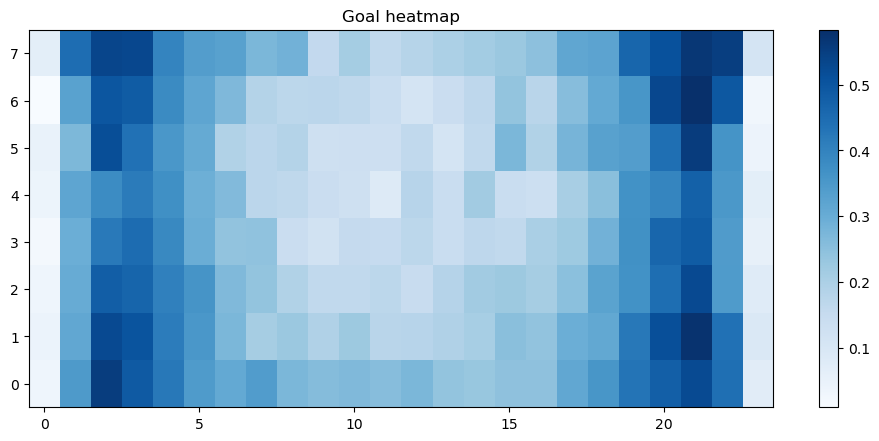

In [42]:
fig, ax = plt.subplots(figsize=(12, 5), dpi=100)
im = ax.imshow(hist.T, cmap="Blues",origin='lower', aspect='auto')
ax.set_title("Goal heatmap")
fig.colorbar(im, ax=ax)